In [819]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np

In [820]:
# Import data

driver_df = pd.read_csv("data/drivers.csv")
constructors_df = pd.read_csv("data/constructors.csv")

lap_times_df = pd.read_csv("data/lap_times.csv")
qualifying_df = pd.read_csv("data/qualifying.csv")

races_df = pd.read_csv("data/races.csv")
results_df = pd.read_csv("data/results.csv")
status_df = pd.read_csv("data/status.csv")
standings_df = pd.read_csv("data/driver_standings.csv")

In [821]:
# Change the races_df to have a datetime index
races_df["date"] = pd.to_datetime(races_df["date"])
races_df = races_df.set_index("date")

In [822]:
# Create a dataframe with race ID and date. And a function to add the date as the index of other dataframes
id_date = pd.DataFrame()
id_date["raceId"] = races_df["raceId"]
id_date = id_date.reset_index()


def raceId_to_date(df):
    df = df.merge(id_date, how="left", on="raceId").set_index("date").sort_index()
    return df

In [855]:
# Function to look up driver id
def lookup_driver(name):
    display(driver_df[driver_df["surname"] == name])


# Function to look up race id
def lookup_race(name):
    display(races_df[races_df["name"].str.contains(name)])


# Function to look up laptimes from specific race and driver
def lookup_laptimes(race, driver):
    df = lap_times_df[lap_times_df["driverId"] == driver]
    df = df[df["raceId"] == race]
    df = df.set_index("lap").sort_index()
    return df


# Function to look up results from specific race and driver
def lookup_result(race, driver):
    df = results_df[results_df["driverId"] == driver]
    df = df[df["raceId"] == race]
    return df


# Function to look up results from specific race and driver
def lookup_constructor_result(race, constructor):
    df = results_df[results_df["constructorId"] == constructor]
    df = df[df["raceId"] == race]
    return df


# Function to look op the teammate at a race of a specific driver
def get_teammate(race, driver):
    teammate_id = 0
    teammate_id = list(
        lookup_constructor_result(
            race, lookup_result(race, driver)["constructorId"].item()
        )["driverId"]
    )
    teammate_id.remove(driver)
    #teammate_name = driver_df[driver_df["driverId"] == teammate_id[0]]["surname"].item()
    if teammate_id:
        return (teammate_id[0])
    else:
        return driver


# Plot the laptimes of a driver at a race and also those of his teammate
def plot_laptimes(race, driver):
    lookup_laptimes(race, driver)["milliseconds"].plot()
    lookup_laptimes(race, get_teammate(race, driver))["milliseconds"].plot()


# Get a result of a drive and his teammate of a certain race (f.e. "grid", "position")
def compare_result(race, driver, kind):
    own_result = lookup_result(race, driver)[kind].item()
    teammate_result = lookup_result(race, get_teammate(race, driver))[kind].item()
    return (own_result, teammate_result)


# Get a list of races which the driver participated in
def get_driver_races(driver):
    races_list = list(results_df[results_df["driverId"] == driver]["raceId"])
    return races_list


# Get all results of a certain kind of a driver and his teammate, and score the driver on his performance compared to his teammate
def compare_all_results(driver, kind, score_scale, roll, plot):
    result_list = []
    for race in get_driver_races(driver):
        result_list.append(compare_result(race, driver, kind))
        
    compare_df = (
        pd.DataFrame(
            data=result_list,
            index=get_driver_races(driver),
            columns=["own", "teammate"],
        )
        .reset_index()
        .rename(columns={"index": "raceId"})
    )

    compare_df = raceId_to_date(compare_df)
    compare_df["difference"] = compare_df["teammate"] - compare_df["own"]
    compare_df["minus"] = compare_df["difference"] / abs(compare_df["difference"])
    #compare_df["score"] = compare_df["minus"] * (compare_df["difference"]**2) / (score_scale)**2
    compare_df["score"] = (compare_df["difference"]) / (score_scale)
    compare_df["noroll_score"] = compare_df["score"]
    compare_df["score"] = compare_df["score"].rolling(roll).mean()

    # Only get data from 2010, as the point system changed since then
    #compare_df = compare_df.loc["1980":]

    if plot:
        plt.figure(figsize=(10, 7))
        plt.plot(compare_df["score"])
        plt.gca().set_ylim([-1, 1])
        plt.title("Race Perfomance against Teammates")
        plt.grid()
    return compare_df

def average(list):
    return sum(list) / len(list)

In [824]:
results_df = raceId_to_date(results_df)
results_df = results_df.replace({"\\N" : -1})
lap_times_df = raceId_to_date(lap_times_df)

In [825]:
driver_list = list(results_df["driverId"].unique())

In [826]:
for driver in list(results_df.loc["2023"]["driverId"].unique()):
    driver_list.remove(driver)

  0%|          | 0/836 [00:00<?, ?it/s]

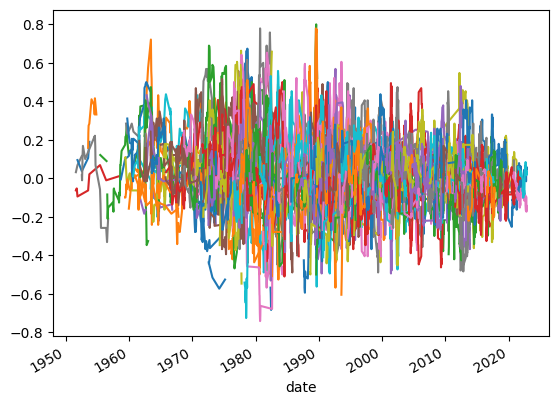

In [827]:
result = []
fig, ax = plt.subplots()
for driver in tqdm(driver_list):
    try:
        temp_result = compare_all_results(driver, "positionOrder", 19, 10, False)
        result.append(temp_result)
        temp_result["score"].plot(ax=ax)
    except:
        pass
plt.show()

In [903]:
all_mean = []
last_mean = []
for i in range(1,10):
    for df in result:
        temp_last_mean = []
        df = df.fillna(0)
        all_mean.append(df["noroll_score"].mean())
        temp_last_mean.append(df["noroll_score"].tail(i).mean())
    last_mean.append(average(temp_last_mean))

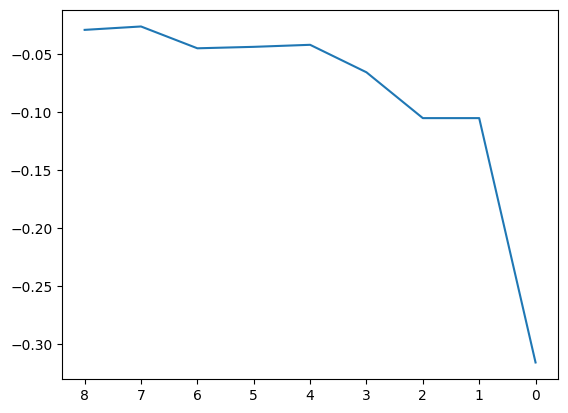

In [904]:
plt.plot(last_mean)
plt.gca().invert_xaxis()

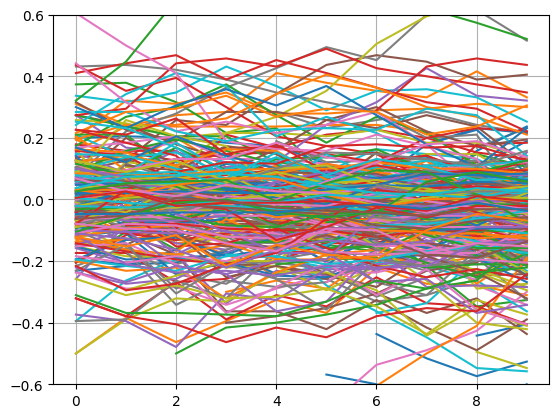

In [831]:
fig2, ax2 = plt.subplots()

for df in result:
    df.tail(10).reset_index()["score"].plot(ax=ax2)
fig2 = plt.gca().set_ylim([-0.6, 0.6])
fig2 = plt.grid()